In [2]:
pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   - -------------------------------------- 0.8/16.4 MB 6.7 MB/s eta 0:00:03
   --- ------------------------------------ 1.3/16.4 MB 3.4 MB/s eta 0:00:05
   ----- ---------------------------------- 2.1/16.4 MB 3.4 MB/s eta 0:00:05
   -------- ------------------------------- 3.4/16.4 MB 4.2 MB/s eta 0:00:04
   ----------- ---------------------------- 4.7/16.4 MB 4.4 MB/s eta 0:00:03
   ------------- -------------------------- 5.5/16.4 MB 4.5 MB/s eta 0:00:03
   ----------------- ---------------------- 7.1/16.4 MB 4.8 MB/s eta 0:00:02
   -------------------- ------------------- 8.4/16.4 MB 4.9 MB/s eta 0:00:02
   ----------------------- ---------------- 9.4/16.4 MB 5.0 MB/s eta 0:00:02
   -------------------------- ------------- 10.7/16.4 MB 5.2 MB/s eta 0:00:02
   ----------------------------- ---------- 12.1/16.4 MB 5.2 MB/s eta 0:00:01
   

In [7]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Abhisek15@',
    database='interview'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/lenovo/OneDrive/Desktop/Abhisek P/datasets-20250327T075344Z-001/datasets/E commerce datasets'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Abhisek15@",
                            database = "interview")

cur = db.cursor()

# List all unique cities where customers are located.

In [12]:
query = """ select distinct customer_city from customers """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017.

In [16]:
query = """ select count(order_id) from orders2 where year(order_purchase_timestamp) = 2017 """

cur.execute(query)
data = cur.fetchall()
data[0][0]


45101

# Find the total sales per category.

In [19]:
query = """ select upper(p1.product_category) as category, 
round(sum(p.payment_value),2) as sales
from products1 p1 join order_items 
on p1.product_id = order_items.product_id
join payments p 
on p.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

In [2]:
query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state.

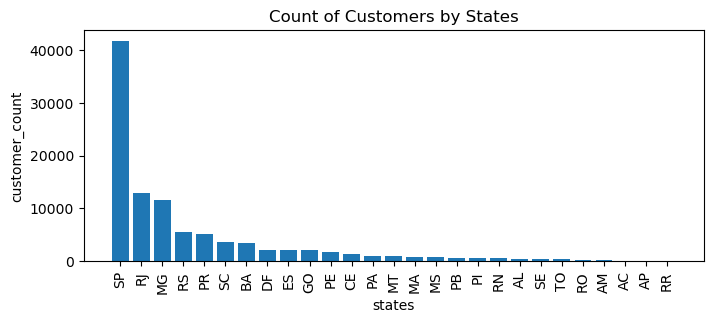

In [11]:
query = """ select customer_state,count(customer_id)
            from customers
            group by customer_state"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer_State","No_of_Customer"])
df = df.sort_values(by = "No_of_Customer",ascending=False)
plt.figure(figsize = (8,3))
plt.bar(df["Customer_State"],df["No_of_Customer"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

# Calculate the number of orders per month in 2018.

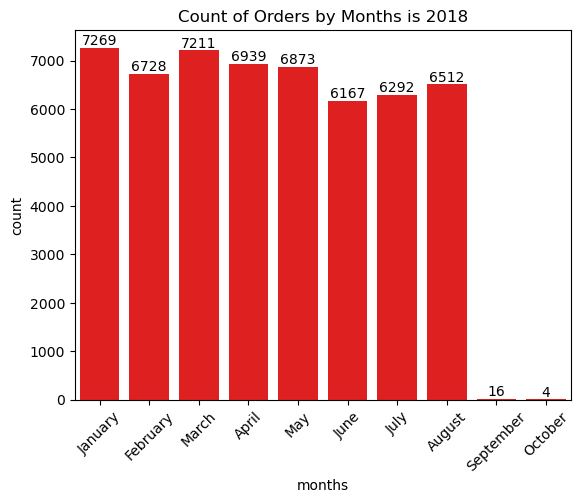

In [17]:
query = """select monthname(order_purchase_timestamp) as months,count(order_id) as count
from orders2
where year(order_purchase_timestamp) = 2018
group by months
order by months"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["months","count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]
ax = sns.barplot(x = df["months"],y =  df["count"], data = df, order = o, color = "red")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")
plt.show()

# Find the average number of products per order, grouped by customer city.

In [14]:
query = """with count_per_order as (
select o.order_id,o.customer_id,count(oi.order_id) as count_orders
from orders2 o join order_items oi
on o.order_id = oi.order_id
group by o.order_id,o.customer_id
)
select c.customer_city,round(avg(co.count_orders),2) as avg_orders
from customers c join count_per_order co
on c.customer_id = co.customer_id
group by c.customer_city
order by avg_orders desc"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["City","Avg_orders"])
df

,City,Avg_orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
...,...,...
4105,sebastiao leal,1.00
4106,morro agudo de goias,1.00
4107,santa filomena,1.00
4108,guamiranga,1.00


# Calculate the percentage of total revenue contributed by each product category.

In [16]:
query = """select prod.product_category as category
,round((sum(p.payment_value)/(select sum(payment_value) from payments)*100.0),2) as percentage_count
from products1 prod join order_items oi
on prod.product_id = oi.product_id
join payments p 
on p.order_id = oi.order_id
group by category
order by percentage_count desc"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["category","percentage_count"])
df

,category,percentage_count
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
...,...,...
69,House Comfort 2,0.01
70,cds music dvds,0.01
71,PC Gamer,0.01
72,Fashion Children's Clothing,0.00


# Identify the correlation between product price and the number of times a product has been purchased.

In [24]:
import numpy as np
query = """select products1.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products1 join order_items
on products1.product_id = order_items.product_id
group by products1.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])
arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

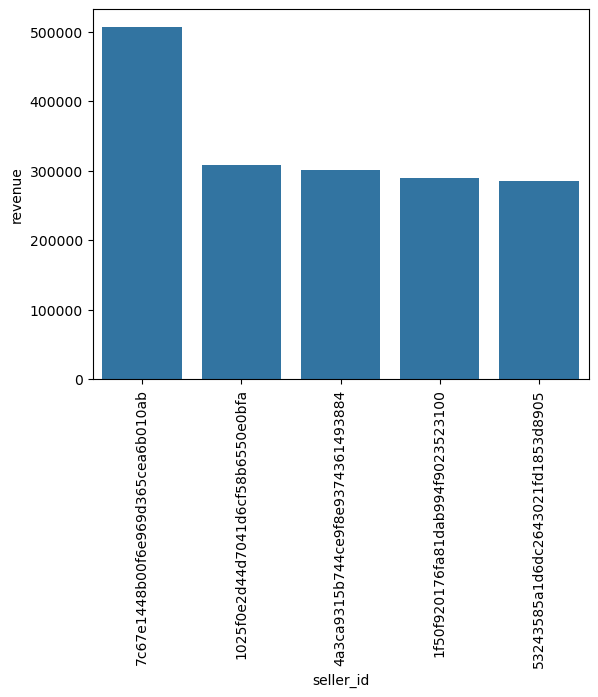

In [2]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [3]:
query = """select customer_id,order_purchase_timestamp,payment
,avg(payment) over (partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as
mov_avg from 
(select o.customer_id,o.order_purchase_timestamp,p.payment_value as payment
from orders2 o join payments p 
on p.order_id = o.order_id) a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year.

In [5]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(o.order_purchase_timestamp) as years,
month(o.order_purchase_timestamp) as months,
round(sum(p.payment_value),2) as payment from orders2 o join payments p
on o.order_id = p.order_id
group by years, months order by years, months) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


# Calculate the year-over-year growth rate of total sales.

In [6]:
query = """with cte as (
select year(order_purchase_timestamp) as years,sum(payment_value) as payment
from orders2 o join payments p
on o.order_id = p.order_id
group by years
order by years
),cte2 as (
select *,lag(payment,1) over (order by years) as prev_order_sales
from cte
)
select years,round((payment - prev_order_sales)*100.0/prev_order_sales,2) as YOY
from cte2"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Years","YOY"])
df

,Years,YOY
0,2016,NaN
1,2017,12112.7
2,2018,20.0


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [7]:
query = """with a as (
select c.customer_id,min(order_purchase_timestamp) as first_order
from customers c join orders2 o
on c.customer_id = o.customer_id
group by c.customer_id
),
b as (select a.customer_id,count(distinct o.order_purchase_timestamp) as next_order
from a join orders2 o
on o.customer_id = a.customer_id
and o.order_purchase_timestamp > first_order
and o.order_purchase_timestamp < 
date_add(first_order,interval 6 month)
group by a.customer_id)
select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) as retention
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()
data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

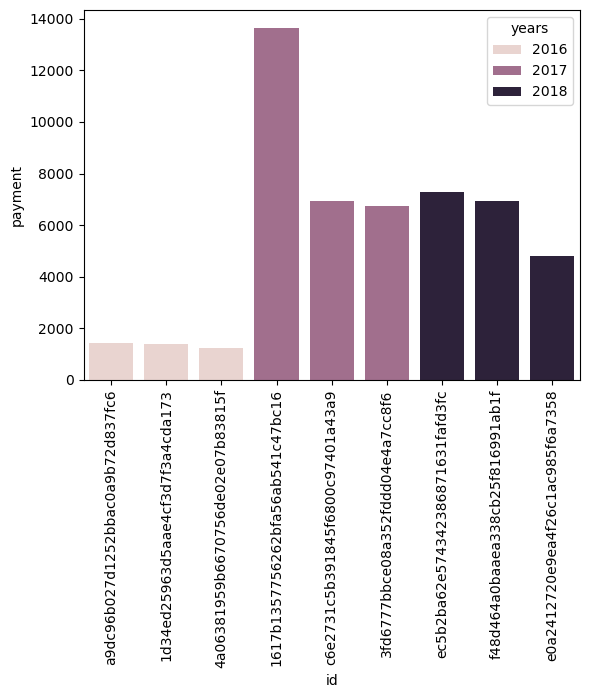

In [10]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders2.order_purchase_timestamp) years,
orders2.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders2.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders2 join payments 
on payments.order_id = orders2.order_id
group by year(orders2.order_purchase_timestamp),
orders2.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()